# LABORATORUL 2

In [14]:
import os
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data_clusters
from pyod.models.knn import KNN
from sklearn.metrics import balanced_accuracy_score
from sklearn.datasets import make_blobs
from pyod.models.lof import LOF
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pyod.utils.utility import standardizer
from pyod.models.combination import average, maximization

In [15]:
output_dir_ex1 = "plots_ex_1"
os.makedirs(output_dir_ex1, exist_ok=True)

output_dir_ex2 = "plots_ex2"
os.makedirs(output_dir_ex2, exist_ok=True)

output_dir_ex3 = "plots_ex3"
os.makedirs(output_dir_ex3, exist_ok=True)

## Exercitiul 1


In [44]:
def generate_linear_data(dim:int=1, n:int=100, a:float=2.0, b:float=1.0, c:float=3.0, mu:float=0,
                         sigma2:float=0.5, var_x:bool=False, var_y:bool=False) -> tuple:
    if dim == 1:
        x = np.random.uniform(-10, 10, n) if var_x else np.random.uniform(-2, 2, n)
        noise = np.random.normal(mu, np.sqrt(sigma2 * (10 if var_y else 1)), n)
        y = a * x + b + noise
        X = np.vstack([np.ones_like(x), x]).T
        return X, y, x

    else:
        x1 = np.random.uniform(-10, 10, n) if var_x else np.random.uniform(-2, 2, n)
        x2 = np.random.uniform(-10, 10, n) if var_x else np.random.uniform(-2, 2, n)
        noise = np.random.normal(mu, np.sqrt(sigma2 * (10 if var_y else 1)), n)
        y = a * x1 + b * x2 + c + noise
        X = np.vstack([np.ones_like(x1), x1, x2]).T
        return X, y, x1, x2



def compute_leverage(X: np.ndarray) -> np.ndarray:
    H = X @ np.linalg.inv(X.T @ X) @ X.T
    return np.diag(H)


def plot_leverage_1d() -> None:
    os.makedirs(output_dir_ex1, exist_ok=True)
    save_path = os.path.join(output_dir_ex1, "leverage_1d.png")

    a, b = 2.0, 1.0
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    axs = axs.flatten()

    subplots = [
        ("Normal", False, False),
        ("High var X", True, False),
        ("High var Y", False, True),
        ("High var on both", True, True)
    ]

    for i, (title, var_x, var_y) in enumerate(subplots):
        X, y, x = generate_linear_data(dim=1, n=100, a=a, b=b, mu=0, sigma2=1.0, var_x=var_x, var_y=var_y)
        h = compute_leverage(X)
        idx_max = np.argmax(h)

        sc = axs[i].scatter(x, y, c=h, cmap='viridis', s=50)
        axs[i].scatter(x[idx_max], y[idx_max], color='red', s=100, label='Highest leverage')
        axs[i].plot(np.sort(x), a * np.sort(x) + b, 'r--', lw=1)
        axs[i].set_xlabel("x")
        axs[i].set_ylabel("y")
        axs[i].legend()
        plt.colorbar(sc, ax=axs[i], label="Leverage")

    plt.tight_layout()
    plt.suptitle("Leverage Scores – 1D", y=1.02)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)


def plot_leverage_2d() -> None:
    os.makedirs(output_dir_ex1, exist_ok=True)
    save_path = os.path.join(output_dir_ex1, "leverage_2d.png")

    fig = plt.figure(figsize=(14, 10))
    titles = ["Normal", "High var X", "High var Y", "High var XY"]
    subplots = [(False, False), (True, False), (False, True), (True, True)]

    for i, (var_x, var_y) in enumerate(subplots):
        ax = fig.add_subplot(2, 2, i + 1, projection='3d')
        X, y, x1, x2 = generate_linear_data(dim=2, n=200, a=1.5, b=-2.0, c=3.0, mu=0, sigma2=0.5, var_x=var_x, var_y=var_y)
        h = compute_leverage(X)
        idx_max = np.argmax(h)

        beta = np.linalg.inv(X.T @ X) @ X.T @ y
        a_hat, b_hat, c_hat = beta[1], beta[2], beta[0]

        grid_x1, grid_x2 = np.meshgrid(np.linspace(min(x1), max(x1), 30),
                                       np.linspace(min(x2), max(x2), 30))
        grid_y = a_hat * grid_x1 + b_hat * grid_x2 + c_hat

        sc = ax.scatter(x1, x2, y, c=h, cmap='plasma', s=40)
        ax.scatter(x1[idx_max], x2[idx_max], y[idx_max], color='red', s=100, label='Highest lev')
        ax.plot_surface(grid_x1, grid_x2, grid_y, alpha=0.3, color='gray')
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.set_zlabel("y")
        ax.legend()

    plt.tight_layout()
    cbar = fig.colorbar(sc, ax=fig.axes, orientation='vertical', fraction=0.03, pad=0.1)
    cbar.set_label("Lev")
    plt.suptitle("Lev Scores 2D", y=1.03)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)


plot_leverage_1d()
plot_leverage_2d()
print("Saved")


Saved


## Exercitiul 2

In [46]:
X_train, X_test, y_train, y_test = generate_data_clusters(
    n_train=400,
    n_test=200,
    n_clusters=2,
    contamination=0.1,
    random_state=42
)

valori_k = [3, 5, 10, 20]
rezultate_path = os.path.join(output_dir_ex2, "results.txt")

with open(rezultate_path, "w") as f:
    f.write("Results AD")

for k in valori_k:
    model = KNN(n_neighbors=k)
    model.fit(X_train)

    pred_train = model.labels_
    pred_test = model.predict(X_test)

    acc_train = balanced_accuracy_score(y_train, pred_train)
    acc_test = balanced_accuracy_score(y_test, pred_test)

    with open(rezultate_path, "a") as f:
        f.write(f"k = {k}\n")
        f.write(f"Train balanced acc: {acc_train:.3f}\n")
        f.write(f"Test balanced acc:  {acc_test:.3f}\n\n")

    fig, axs = plt.subplots(2, 2, figsize=(9, 8))
    fig.suptitle(f"KNN (k={k})", fontsize=13)

    axs[0, 0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=18)
    axs[0, 1].scatter(X_train[:, 0], X_train[:, 1], c=pred_train, s=18)
    axs[1, 0].scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=18)
    axs[1, 1].scatter(X_test[:, 0], X_test[:, 1], c=pred_test, s=18)

    titluri = ["Train real", "Train predict", "Test real", "Test predict"]
    for ax, t in zip(axs.ravel(), titluri):
        ax.set_title(t, fontsize=10)
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")

    plt.tight_layout(rect=[0, 0.02, 1, 0.94])
    fig.savefig(os.path.join(output_dir_ex2, f"knn_k_{k}.png"), dpi=300)
    plt.close(fig)


## Exercitiul 3


In [49]:
X, y_base = make_blobs(
    n_samples=[200, 100],
    centers=[(-10, -10), (10, 10)],
    cluster_std=[2, 6],
    n_features=2,
    random_state=42
)

cont_rate = 0.07
k_values = [5, 10, 20]

margin = 5
x_range = (X[:, 0].min() - margin, X[:, 0].max() + margin)
y_range = (X[:, 1].min() - margin, X[:, 1].max() + margin)

def show_result(ax: plt.Axes, data: np.ndarray, lbls: np.ndarray, title: str) -> None:
    normal = data[lbls == 0]
    anomaly = data[lbls == 1]
    ax.scatter(normal[:, 0], normal[:, 1], s=22, alpha=0.9, label="Inliers")
    ax.scatter(anomaly[:, 0], anomaly[:, 1], s=28, alpha=0.9, marker="x", label="Outliers")
    ax.set_xlim(*x_range)
    ax.set_ylim(*y_range)
    ax.set_title(title)
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    ax.legend(frameon=False)
    ax.grid(ls="--", alpha=0.4)

for k in k_values:
    model_knn = KNN(n_neighbors=k, contamination=cont_rate)
    model_knn.fit(X)
    pred_knn = model_knn.labels_

    model_lof = LOF(n_neighbors=k, contamination=cont_rate)
    model_lof.fit(X)
    pred_lof = model_lof.labels_

    fig, ax = plt.subplots(1, 2, figsize=(11, 5.2))
    fig.suptitle(f"KNN vs LOF  |  k={k}, contamination={cont_rate}", fontsize=12)

    show_result(ax[0], X, pred_knn, "KNN Prediction")
    show_result(ax[1], X, pred_lof, "LOF Prediction")

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    out_path = os.path.join(output_dir_ex3, f"comparison_k_{k}.png")
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)


## Exercitiul 4


Shape: (1831, 21), contamination=0.096

KNN model (k=30)
Train BA: 0.707, Test BA: 0.674

KNN model (k=40)
Train BA: 0.716, Test BA: 0.686

KNN model (k=50)
Train BA: 0.725, Test BA: 0.715

KNN model (k=60)
Train BA: 0.725, Test BA: 0.724

KNN model (k=70)
Train BA: 0.734, Test BA: 0.743

KNN model (k=80)
Train BA: 0.748, Test BA: 0.752

KNN model (k=90)
Train BA: 0.752, Test BA: 0.752

KNN model (k=100)
Train BA: 0.752, Test BA: 0.752

KNN model (k=110)
Train BA: 0.748, Test BA: 0.753

KNN model (k=120)
Train BA: 0.752, Test BA: 0.764
     k  BA_train   BA_test
0   30  0.707275  0.673968
1   40  0.716269  0.686420
2   50  0.725262  0.714722
3   60  0.725262  0.724156
4   70  0.734256  0.743024
5   80  0.747746  0.752458
6   90  0.752243  0.752458
7  100  0.752243  0.752458
8  110  0.747746  0.753464
9  120  0.752243  0.763904


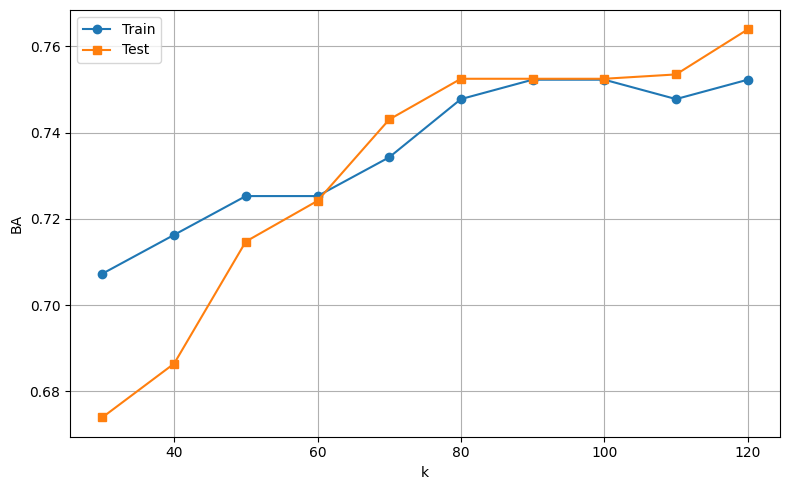

Average Train: 0.730, Test: 0.743
Maximum Train: 0.752, Test: 0.752


In [61]:
nudata = loadmat("cardio.mat")
x = data["X"]
y = data["y"].ravel().astype(int)

print(f"Shape: {x.shape}, contamination={y.mean():.3f}")

x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

sc = StandardScaler()
x_tr = sc.fit_transform(x_tr)
x_te = sc.transform(x_te)

cont = y.mean()
k_vals = np.arange(30, 121, 10)

ba_tr_list, ba_te_list = [], []
sc_tr_list, sc_te_list = [], []

for k in k_vals:
    print(f"\nKNN model (k={k})")
    model = KNN(n_neighbors=k, contamination=cont)
    model.fit(x_tr)

    pred_tr = model.labels_
    pred_te = model.predict(x_te)

    ba_tr = balanced_accuracy_score(y_tr, pred_tr)
    ba_te = balanced_accuracy_score(y_te, pred_te)

    print(f"Train BA: {ba_tr:.3f}, Test BA: {ba_te:.3f}")

    ba_tr_list.append(ba_tr)
    ba_te_list.append(ba_te)

    sc_tr_list.append(model.decision_scores_)
    sc_te_list.append(model.decision_function(x_te))

sc_tr_list, sc_te_list = np.array(sc_tr_list), np.array(sc_te_list)

sc_tr_norm, sc_te_norm = standardizer(sc_tr_list.T, sc_te_list.T)

avg_tr, avg_te = average(sc_tr_norm), average(sc_te_norm)
max_tr, max_te = maximization(sc_tr_norm), maximization(sc_te_norm)

def eval_strat(tr_vals: np.ndarray, te_vals: np.ndarray, y_tr: np.ndarray, y_te: np.ndarray, cont: float) -> tuple:
    thr = np.quantile(tr_vals, 1 - cont)
    pr_tr = (tr_vals > thr).astype(int)
    pr_te = (te_vals > thr).astype(int)
    return balanced_accuracy_score(y_tr, pr_tr), balanced_accuracy_score(y_te, pr_te)

ba_avg_tr, ba_avg_te = eval_strat(avg_tr, avg_te, y_tr, y_te, cont)
ba_max_tr, ba_max_te = eval_strat(max_tr, max_te, y_tr, y_te, cont)

df = pd.DataFrame({"k": k_vals, "BA_train": ba_tr_list, "BA_test": ba_te_list})

print(df)

plt.figure(figsize=(8, 5))
plt.plot(k_vals, ba_tr_list, "o-", label="Train")
plt.plot(k_vals, ba_te_list, "s-", label="Test")
plt.xlabel("k")
plt.ylabel("BA")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Average Train: {ba_avg_tr:.3f}, Test: {ba_avg_te:.3f}")
print(f"Maximum Train: {ba_max_tr:.3f}, Test: {ba_max_te:.3f}")
